In [1]:
import os
import sys

import numpy as np
import shutil
import json
import time
from typing import Union, List

In [2]:
def read_class_names(classes: Union[str, List[str]]):
    """
    Returns a dictionary of class names and IDs

    classes: path to class names file or list of class names
    """

    # loads class name from a file
    names = {}

    if isinstance(classes, str):
        with open(classes, "r") as data:
            for ID, name in enumerate(data):
                names[ID] = name.strip("\n")
    else:
        for ID, name in enumerate(classes):
            names[ID] = name
    return names

In [3]:
def voc_ap(rec, prec):
    """
    --- Official matlab code VOC2012---
    mrec=[0 ; rec ; 1];
    mpre=[0 ; prec ; 0];
    for i=numel(mpre)-1:-1:1
            mpre(i)=max(mpre(i),mpre(i+1));
    end
    i=find(mrec(2:end)~=mrec(1:end-1))+1;
    ap=sum((mrec(i)-mrec(i-1)).*mpre(i));
    """
    mrec = np.array([0., *rec, 1.])
    mpre = np.array([0., *prec, 0.])
    mpre = np.maximum.accumulate(mpre[::-1])[::-1]
    idx = np.argwhere(mrec[1:] != mrec[:-1])
    ap = np.sum((mrec[idx + 1] - mrec[idx]) * mpre[idx + 1])
    return ap, mrec, mpre

In [4]:
def get_mAP(Yolo, dataset, NUM_CLASS, score_threshold=0.05, iou_threshold=0.45, filter_fn=None, min_overlap=0.5):
    ground_truth_dir_path = "mAP/ground-truth"
    if os.path.exists(ground_truth_dir_path):
        shutil.rmtree(ground_truth_dir_path)

    if not os.path.exists("mAP"):
        os.mkdir("mAP")
    os.mkdir(ground_truth_dir_path)

    print(f"\ncalculating mAP{int(min_overlap*100)}...\n")

    gt_counter_per_class = {}
    ground_truth_data = []
    for index in range(len(dataset)):
        image_path, bbox_data_gt = dataset[index]

        if len(bbox_data_gt) == 0:
            bboxes_gt = []
            classes_gt = []
        else:
            bboxes_gt, classes_gt = bbox_data_gt[:, :4], bbox_data_gt[:, 4]
        num_bbox_gt = len(bboxes_gt)

        bounding_boxes = []
        for i in range(num_bbox_gt):
            class_name = NUM_CLASS[classes_gt[i]]
            xmin, ymin, xmax, ymax = list(map(str, bboxes_gt[i]))
            bbox = " ".join((xmin, ymin, xmax, ymax))
            bounding_boxes.append(
                {"class_name": class_name, "bbox": bbox, "used": False}
            )

            if class_name not in gt_counter_per_class:
                gt_counter_per_class[class_name] = 0

            gt_counter_per_class[class_name] += 1
        
        new_gt_path = f"{ground_truth_dir_path}/{index}_ground_truth.json"
        with open(new_gt_path, "w") as outfile:
            json.dump(bounding_boxes, outfile)
        
        ground_truth_data.append(bounding_boxes)
    
    gt_classes = list(gt_counter_per_class.keys())
    # sort the classes alphabetically
    gt_classes = sorted(gt_classes)
    n_classes = len(gt_classes)

    times = []
    json_pred = [[] for i in range(n_classes)]
    preds = []
    for index in range(len(dataset)):
        image_path, bbox_data_gt = dataset[index]

        t1 = time.time()
        bboxes = Yolo(image_path, score_threshold=score_threshold)
        t2 = time.time()

        times.append(t2 - t1)

        for bbox in bboxes:
            coor = np.array(bbox[:4], dtype=np.int32)
            score = bbox[4]
            class_ind = int(bbox[5])
            lat, lon, rad = bbox[6:9]

            if class_ind >= len(NUM_CLASS):
                continue

            class_name = NUM_CLASS[class_ind]
            score = "%.4f" % score
            xmin, xmax, ymin, ymax = list(map(str, coor))
            bbox = xmin + " " + ymin + " " + xmax + " " + ymax

            # if class_name == "bus":
            #     class_name = "truck"
            # elif class_name in ["cyclist", "minibus"]:
            #     class_name = "car"
            class_name = "car"

            preds.append(
                {
                    "confidence": score,
                    "file_id": index,
                    "bbox": str(bbox),
                    "lat": lat,
                    "lon": lon,
                    "rad": rad,
                    "class_name": class_name
                }
            )

    ms = sum(times) / len(times) * 1000
    fps = 1000 / ms

    print(f'Number detections:{len(preds)}')

    # filter out predictions based on filter function
    if filter_fn is not None:
        num_preds = len(preds)
        preds = filter_fn(preds)

    for pred in preds:
        json_pred[gt_classes.index(pred["class_name"])].append(pred)

    for class_name in gt_classes:
        json_pred[gt_classes.index(class_name)].sort(
            key=lambda x: x["confidence"], reverse=True
        )

        pred_file = f"{ground_truth_dir_path}/{class_name}_predictions.json"
        with open(pred_file, "w") as outfile:
            json.dump(json_pred[gt_classes.index(class_name)], outfile)

    # Calculate the AP for each class
    sum_AP = 0.0
    ap_dictionary = {}

    recs = []
    precs = []
    filtered_profiles = {
        "duplicate": 0,
        "true positive": 0,
        "ideal": 0,
        "unfiltered no overlap": 0,
        "unfiltered low overlap": 0,
        "unfiltered high overlap": 0,
        "unfiltered true positive": 0,
    }
    count_true_positives = {}
    for class_name in gt_classes:
        count_true_positives[class_name] = 0
        predictions_data = json_pred[gt_classes.index(class_name)]
        valid_indices = []

        # Assign predictions to ground truth objects
        nd = len(predictions_data)
        tp = np.zeros(nd, dtype=int)  # creates an array of zeros of size nd
        fp = np.zeros(nd, dtype=int)
        for idx, prediction in enumerate(predictions_data):
            file_id = prediction["file_id"]
            # assign prediction to ground truth object if any
            gt_file = f"{ground_truth_dir_path}/{file_id}_ground_truth.json"

            ovmax = -1
            gt_match = -1

            # bounding box of prediction
            bb = np.array([float(x) for x in prediction["bbox"].split()])
            for obj in ground_truth_data[file_id]:
                if obj["class_name"] != class_name:
                    continue

                # bounding box of ground truth
                bbgt = [float(x) for x in obj["bbox"].split()]
                bi = [
                    max(bb[0], bbgt[0]),
                    max(bb[1], bbgt[1]),
                    min(bb[2], bbgt[2]),
                    min(bb[3], bbgt[3]),
                ]
                iw = bi[2] - bi[0] + 1
                ih = bi[3] - bi[1] + 1
                
                if iw <= 0 or ih <= 0:
                    # no overlap
                    continue

                # compute overlap (IoU) = area of intersection / area of union
                ua = (
                    (bb[2] - bb[0] + 1) * (bb[3] - bb[1] + 1)
                    + (bbgt[2] - bbgt[0] + 1) * (bbgt[3] - bbgt[1] + 1)
                    - iw * ih
                )
                ov = iw * ih / ua
                # print(f"I:{iw*ih} U:{ua}")
                if ov > ovmax:
                    ovmax = ov
                    gt_match = obj

            # print(prediction)
            if filter_fn is not None:
                if prediction["filtered"]:
                    if ovmax >= min_overlap and gt_match["used"]:
                        filtered_profiles["duplicate"] += 1
                    elif ovmax >= min_overlap:
                        filtered_profiles["true positive"] += 1
                    else:
                        filtered_profiles["ideal"] += 1
                    continue
                elif ovmax < min_overlap:
                    if ovmax < 0.1:
                        filtered_profiles["unfiltered low overlap"] += 1
                    elif ovmax == -1:
                        filtered_profiles["unfiltered no overlap"] += 1
                    else:
                        filtered_profiles["unfiltered high overlap"] += 1
                else:
                    filtered_profiles["unfiltered true positive"] += 1

            valid_indices.append(idx)

            # assign prediction as true positive/don't care/false positive
            if ovmax >= min_overlap and not gt_match["used"]:
                # true positive
                tp[idx] = 1
                gt_match["used"] = True
                count_true_positives[class_name] += 1

                # update the ".json" file
                with open(gt_file, "w") as f:
                    json.dump(ground_truth_data, f)
            else:
                # either not sufficient overlap or duplicate detection
                fp[idx] = 1

        valid_indices = np.array(valid_indices)
        tp = tp[valid_indices]
        fp = fp[valid_indices]

        # compute precision/recall
        tp = np.cumsum(tp)
        fp = np.cumsum(fp)
        rec = tp.astype(float) / gt_counter_per_class[class_name]
        prec = tp.astype(float) / (tp + fp)

        # print(tp, fp, prec)

        ap, mrec, mprec = voc_ap(rec, prec)
        recs.append(mrec)
        precs.append(mprec)

        print('profile of filtered points:')
        print(filtered_profiles)

        sum_AP += ap

        rounded_prec = ["%.3f" % elem for elem in prec]
        rounded_rec = ["%.3f" % elem for elem in rec]
        # Write to results.txt
        print(f"{ap*100:.3f}% = {class_name} AP\nPrecision: {rounded_prec}\nRecall: {rounded_rec}\n\n")
        ap_dictionary[class_name] = ap

        mAP = sum_AP / n_classes

        print(f"mAP = {mAP*100:.3f}%")

        return mAP * 100, recs, precs

In [5]:
from server.engines.engine import EngineLoader
from server.models.header_metadata import HeaderMetadata
from server.layers.gps_translator import GPSTranslationLayer
import server.util.yolo_util as YoloUtil
import PIL.Image
from typing import Tuple, Optional

In [6]:
class ModelWrapper:
    def __init__(
        self,
        model_path: str,
        min_confidence: float = 0.3,
        iou_threshold: float = 0.4,
        input_shape: Tuple[int, int] = (416, 416),
        *args,
        **kwargs,
    ):
        self.model_path = model_path
        self.min_confidence = min_confidence
        self.iou_threshold = iou_threshold
        self.input_shape = input_shape
        assert (
            len(input_shape) == 2
        ), "Model input shape must be a tuple of 2 elements (height, width)"

        self.model = EngineLoader.load(model_path, *args, **kwargs)
        self.gps_translator = GPSTranslationLayer()

    def predict(self, x: str, score_threshold: Optional[float] = None):
        if score_threshold is None:
            score_threshold = self.min_confidence

        img_pil = PIL.Image.open(x)
        img = YoloUtil.preprocess_image(img_pil, self.input_shape)

        predictions = self.model(img)
        boxes, classes, scores = YoloUtil.postprocess_net_output(
            predictions,
            self.input_shape,
            img_pil.size[::-1],
            confidence=score_threshold,
        )

        metadata = HeaderMetadata.read(x)
        gps = np.array(self.gps_translator.run(metadata, np.concatenate([boxes, scores[:, np.newaxis]], axis=-1))).reshape(-1, 4)

        return np.concatenate(
            [boxes, scores[:, np.newaxis], classes[:, np.newaxis], gps[:, :3]], axis=-1
        )

    def __call__(self, *args, **kwargs):
        return self.predict(*args, **kwargs)

In [7]:
def create_dataset(path: str):
    """
    Returns dataset in format:
    [[file_path, [box1, box2, ...]], ...]
    """
    dataset = []

    with open(path) as f:
        dataset_lines = [x.strip() for x in f.readlines() if len(x) > 0]

    for line in dataset_lines:
        file_path, *boxes = [x for x in line.split() if len(x) > 0]
        boxes = [x.replace(" ", "") for x in boxes]
        boxes = [[int(y) for y in x.split(",")] for x in boxes]
        boxes = np.array(boxes, dtype=np.int32).reshape(-1, 5)
        dataset.append([file_path, boxes])

    return dataset

In [8]:
from sklearn.cluster import DBSCAN, HDBSCAN
from geopy.distance import EARTH_RADIUS as EARTH_RADIUS_KM

def create_dbscan_filter(eps, min_samples, metric, *args, **kwargs):
    clustering = DBSCAN(eps=eps, min_samples=min_samples, metric=metric, n_jobs=-1, *args, **kwargs)
    def filter_fn(preds):
        locs = [(p['lat'], p['lon'], p['rad']) for p in preds]
        labels = clustering.fit_predict(locs)

        return [
            {**p, 'filtered': bool(l == -1)} for p, l in zip(preds, labels)
        ]

    return filter_fn

def create_hdbscan_filter(min_cluster_size, metric, *args, **kwargs):
    clustering = HDBSCAN(min_cluster_size=min_cluster_size, metric=metric, n_jobs=-1, *args, **kwargs)
    def filter_fn(preds):
        locs = [(p['lat'], p['lon'], p['rad']) for p in preds]
        labels = clustering.fit_predict(locs)

        return [
            {**p, 'filtered': bool(l == -1)} for p, l in zip(preds, labels)
        ]
    
    return filter_fn

def haversine(x, y):
    def hav(x):
        sinHalf = np.sin(x / 2)
        return sinHalf * sinHalf

    lat1, lon1 = np.deg2rad(x[:2])
    lat2, lon2 = np.deg2rad(y[:2])

    ht = hav(lat2 - lat1) + np.cos(lat1)*np.cos(lat2)*hav(lon2 - lon1)
    return 2 * EARTH_RADIUS_KM * 1000 * np.arcsin(np.sqrt(ht))

def mod_haversine(x, y):
    *x, r1 = x
    *y, r2 = y

    return haversine(x, y) - r1 - r2

In [9]:
CLASSES = ["car", "truck", "bus", "minibus", "cyclist"]
MINOVERLAP = 0.5
NUM_CLASS = read_class_names(CLASSES)

yolo_onnx = ModelWrapper("/home/allanlago/Documents/jupyter-notebooks/rt-flight/yolo/yolov3-aerial.onnx", providers=['CUDAExecutionProvider', 'CPUExecutionProvider'])
yolo = ModelWrapper("/home/allanlago/Documents/jupyter-notebooks/rt-flight/yolo/yolov3-aerial-int8_2.tflite")
# testset = create_dataset("/home/allanlago/temp/TensorFlow-2.x-YOLOv3/aerial-data/all_fixed.txt")
# testset = create_dataset("/home/allanlago/temp/TensorFlow-2.x-YOLOv3/aerial-data/all_with_empty.txt")
testset = create_dataset("/home/allanlago/temp/TensorFlow-2.x-YOLOv3/aerial-data/all_empty_one_class.txt")
# testset = create_dataset("/home/allanlago/temp/TensorFlow-2.x-YOLOv3/aerial-data/stationary.txt")

2023-08-29 19:09:32.113452119 [W:onnxruntime:Default, onnxruntime_pybind_state.cc:640 CreateExecutionProviderInstance] Failed to create CUDAExecutionProvider. Please reference https://onnxruntime.ai/docs/execution-providers/CUDA-ExecutionProvider.html#requirements to ensure all dependencies are met.
2023-08-29 19:09:32.484417154 [W:onnxruntime:Default, upsamplebase.h:101 UpsampleBase] `tf_half_pixel_for_nn` is deprecated since opset 13, yet this opset 13 model uses the deprecated attribute
2023-08-29 19:09:32.484471395 [W:onnxruntime:Default, upsamplebase.h:101 UpsampleBase] `tf_half_pixel_for_nn` is deprecated since opset 13, yet this opset 13 model uses the deprecated attribute


In [10]:
mAPs = []
all_recs = []
all_precs = []

filters = {
    'No filter': None,
    'DBSCAN Hav EPS10': create_dbscan_filter(eps=10, min_samples=2, metric=haversine),
    'DBSCAN Hav EPS20': create_dbscan_filter(eps=20, min_samples=2, metric=haversine),
    'DBSCAN Mod EPS1': create_dbscan_filter(eps=1, min_samples=2, metric=mod_haversine),
    'DBSCAN Mod EPS10': create_dbscan_filter(eps=10, min_samples=2, metric=mod_haversine),
    # 'DBSCAN Mod EPS15': create_dbscan_filter(eps=15, min_samples=2, metric=mod_haversine),
    'DBSCAN Mod EPS20': create_dbscan_filter(eps=20, min_samples=2, metric=mod_haversine),
    # 'DBSCAN Mod EPS25': create_dbscan_filter(eps=25, min_samples=2, metric=mod_haversine),
    # 'DBSCAN Mod EPS30': create_dbscan_filter(eps=30, min_samples=2, metric=mod_haversine),
    'HDBSCAN Hav CSE3e-6': create_hdbscan_filter(min_cluster_size=2, metric=haversine, cluster_selection_epsilon=3e-6),
    'HDBSCAN Mod CSE3e-6': create_hdbscan_filter(min_cluster_size=2, metric=mod_haversine, cluster_selection_epsilon=3e-6),
    # 'HDBSCAN Mod CSE3.5e-6': create_hdbscan_filter(min_cluster_size=2, metric=mod_haversine, cluster_selection_epsilon=3.5e-6),
}

for name, f in filters.items():
    mAP, recs, precs = get_mAP(yolo, testset, NUM_CLASS, score_threshold=0.05, iou_threshold=0.45, filter_fn=f, min_overlap=0.5)

    mAPs.append(mAP)
    all_recs.append(recs[0])
    all_precs.append(precs[0])


calculating mAP50...

Number detections:905
profile of filtered points:
{'duplicate': 0, 'true positive': 0, 'ideal': 0, 'unfiltered no overlap': 0, 'unfiltered low overlap': 0, 'unfiltered high overlap': 0, 'unfiltered true positive': 0}
44.912% = car AP
Precision: ['1.000', '1.000', '1.000', '1.000', '1.000', '1.000', '1.000', '1.000', '1.000', '1.000', '1.000', '1.000', '1.000', '1.000', '1.000', '1.000', '1.000', '1.000', '1.000', '1.000', '1.000', '0.955', '0.957', '0.958', '0.960', '0.962', '0.926', '0.929', '0.931', '0.933', '0.935', '0.938', '0.939', '0.941', '0.943', '0.944', '0.946', '0.947', '0.949', '0.950', '0.951', '0.952', '0.953', '0.955', '0.956', '0.957', '0.957', '0.958', '0.959', '0.960', '0.961', '0.962', '0.962', '0.963', '0.964', '0.964', '0.965', '0.966', '0.966', '0.967', '0.951', '0.952', '0.952', '0.953', '0.954', '0.955', '0.955', '0.956', '0.957', '0.943', '0.944', '0.944', '0.945', '0.946', '0.947', '0.947', '0.948', '0.949', '0.937', '0.938', '0.938', '0

In [11]:
import matplotlib.pyplot as plt

In [12]:
mAP, rec, prec = get_mAP(yolo_onnx, testset, NUM_CLASS, score_threshold=0.05, iou_threshold=0.45, min_overlap=0.5)


calculating mAP50...

Number detections:756
profile of filtered points:
{'duplicate': 0, 'true positive': 0, 'ideal': 0, 'unfiltered no overlap': 0, 'unfiltered low overlap': 0, 'unfiltered high overlap': 0, 'unfiltered true positive': 0}
49.182% = car AP
Precision: ['1.000', '1.000', '1.000', '1.000', '1.000', '1.000', '1.000', '1.000', '1.000', '1.000', '1.000', '1.000', '1.000', '1.000', '1.000', '1.000', '1.000', '1.000', '1.000', '1.000', '1.000', '1.000', '1.000', '1.000', '1.000', '1.000', '1.000', '0.964', '0.966', '0.967', '0.968', '0.969', '0.970', '0.971', '0.971', '0.972', '0.973', '0.974', '0.974', '0.975', '0.976', '0.976', '0.977', '0.977', '0.978', '0.978', '0.979', '0.979', '0.980', '0.980', '0.980', '0.981', '0.981', '0.981', '0.982', '0.982', '0.982', '0.983', '0.966', '0.967', '0.967', '0.968', '0.968', '0.969', '0.969', '0.970', '0.970', '0.971', '0.971', '0.971', '0.972', '0.972', '0.973', '0.973', '0.973', '0.974', '0.974', '0.974', '0.962', '0.963', '0.963', '0

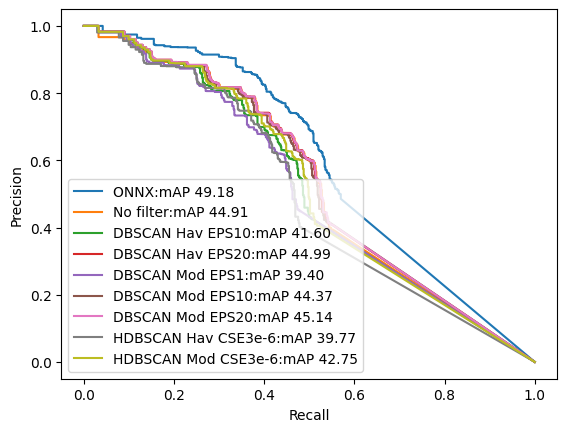

In [13]:
# add onnx to plot
plt.plot(rec[0], prec[0], label=f"ONNX:mAP {mAP:.2f}")

for idx, (filterName, mAP, recs, precs) in enumerate(zip(filters.keys(), mAPs, all_recs, all_precs)):
    plt.plot(recs, precs, label=f"{filterName}:mAP {mAP:.2f}")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()